In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

def genXDayAverage(df, days, tag, **kwargs):
    legalKwargs = ['modifier']
    modifier = None
    if kwargs is not None:
        for key, value in kwargs.items():
            if key in legalKwargs:
                if key == legalKwargs[0]:
                    modifier = value
    print('kwargs done')
    toReturn = np.array([0] * df.shape[0])
    toReturn = pd.Series(toReturn, dtype = 'float64')
    print('preshifting')
    for x in range(days):
        shiftedSeries = df[tag].shift(x)
        if modifier is not None:
            shiftedSeries = modifier(shiftedSeries)
        toReturn = toReturn.add(shiftedSeries)
        print('added a shifted one')
    print('pre return')
    return toReturn.div(days)

combinedDF = pd.read_csv('masterDF.csv', usecols = ['Date', 'ticker', 'vsMarketPerformance', 'SP500Value', 'NASDAQCOMValue'],
                         parse_dates = ['Date'])


In [2]:
def plotChart(df):
    plt.subplots(figsize=(60,20))
    plt.plot(df['Date'], [0.005] * df['Date'].size )
    plt.plot(df['Date'], [-0.005] * df['Date'].size)
    for ticker in df['ticker'].unique():
        tickerDF = df[df['ticker'] == ticker]
        filteredDF = tickerDF[tickerDF['vsMarketPerformance'].abs() > .005]
        tickerDF.sort_values(by = ['Date'])
        plt.scatter(tickerDF['Date'], tickerDF['vsMarketPerformance'], s = 1)
    spxPlot = plt.twinx()
    spxPlot.plot(df['Date'], df['SP500Value'])
    nasdaqPlot = plt.twinx()
    nasdaqPlot.plot(df['Date'], df['NASDAQCOMValue'])
    plt.show()

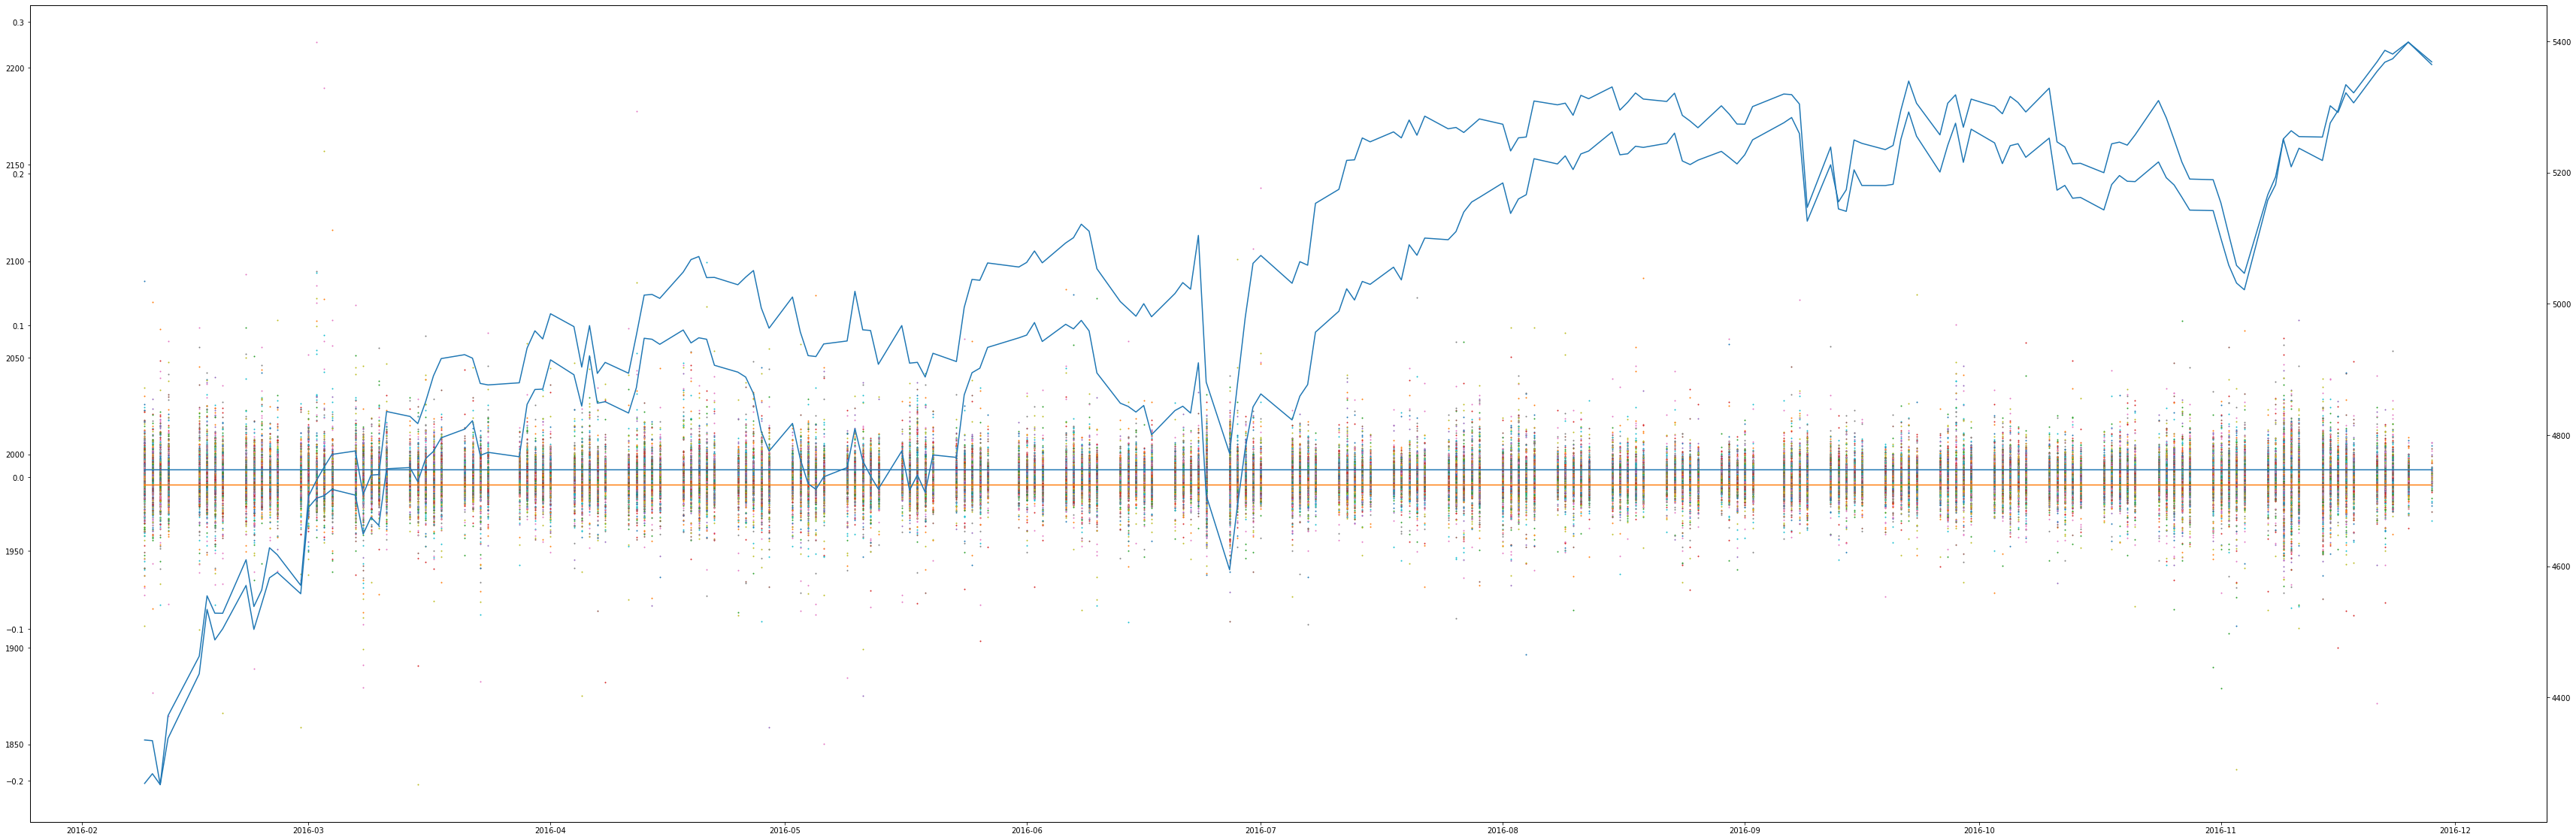

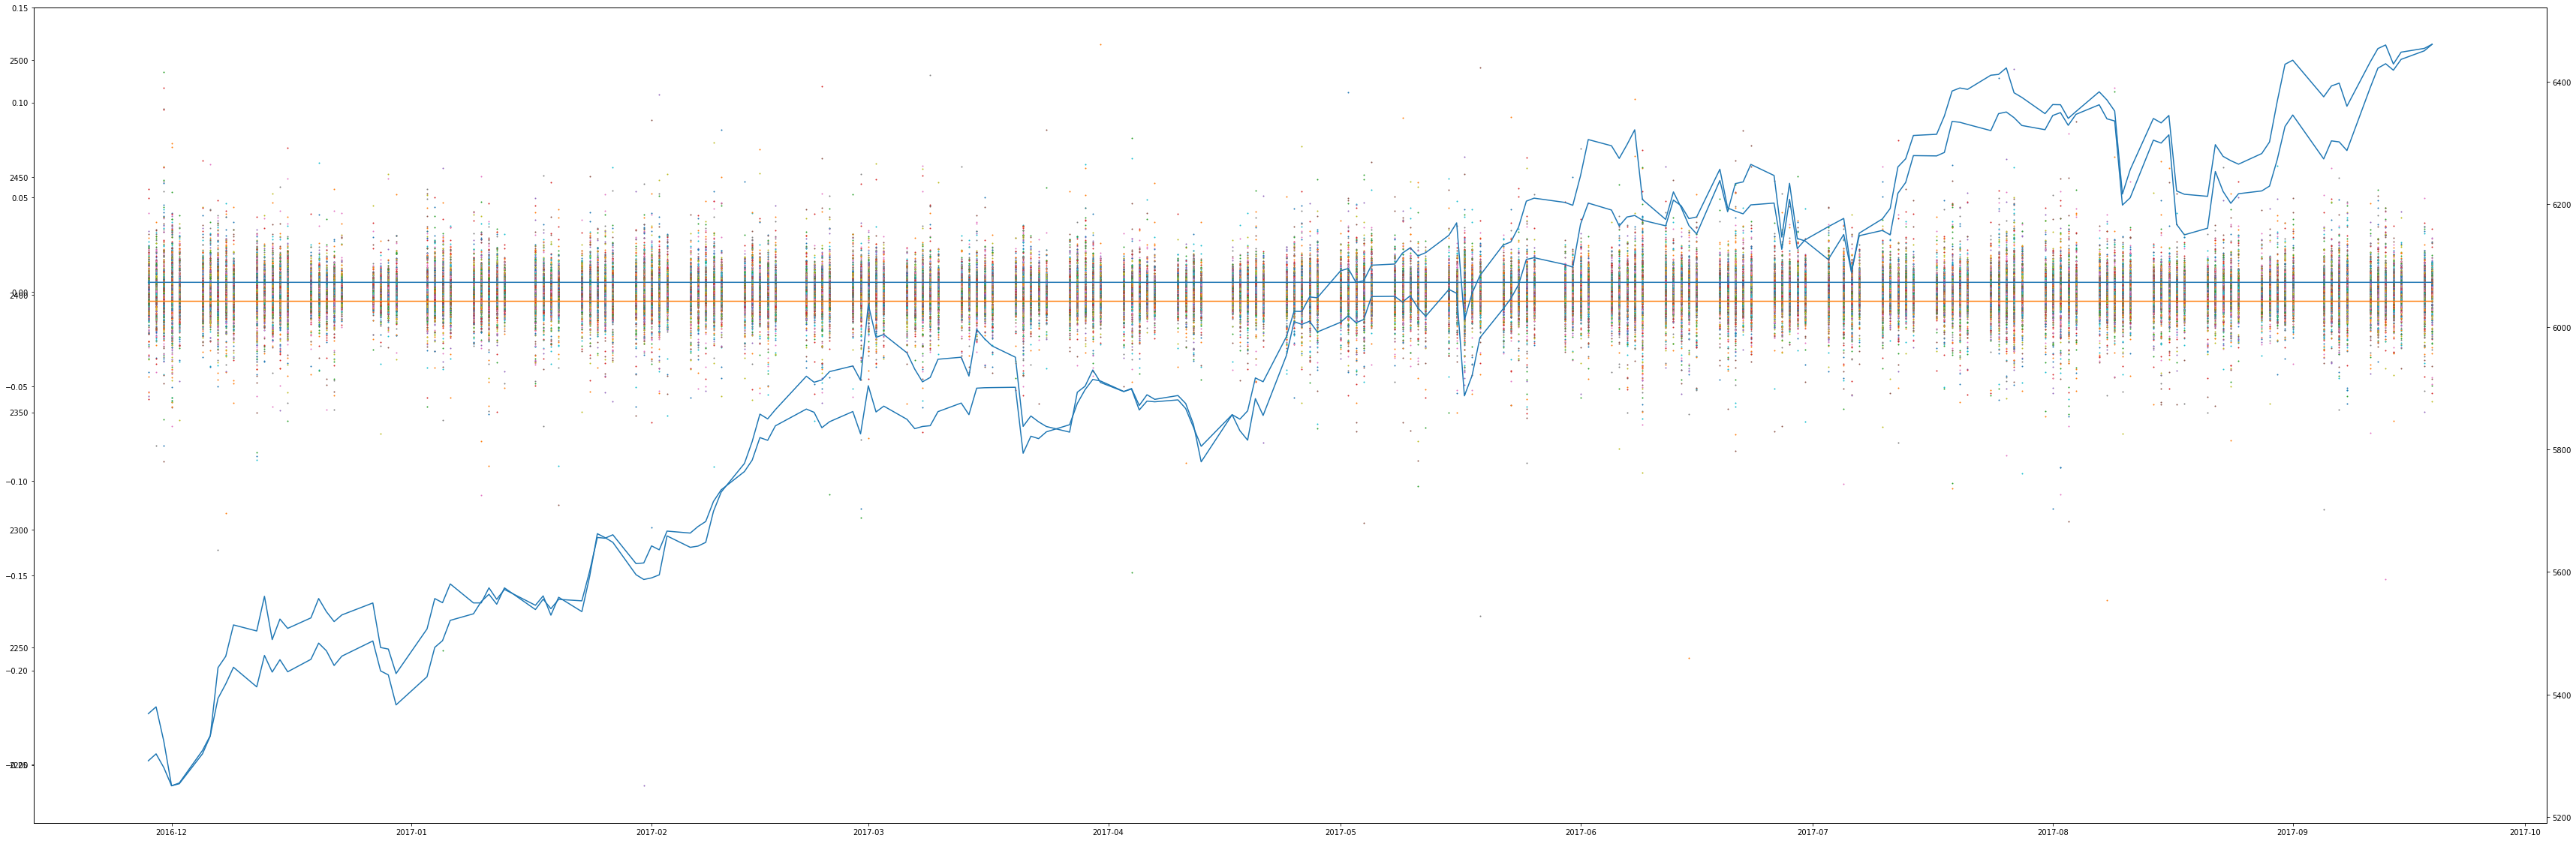

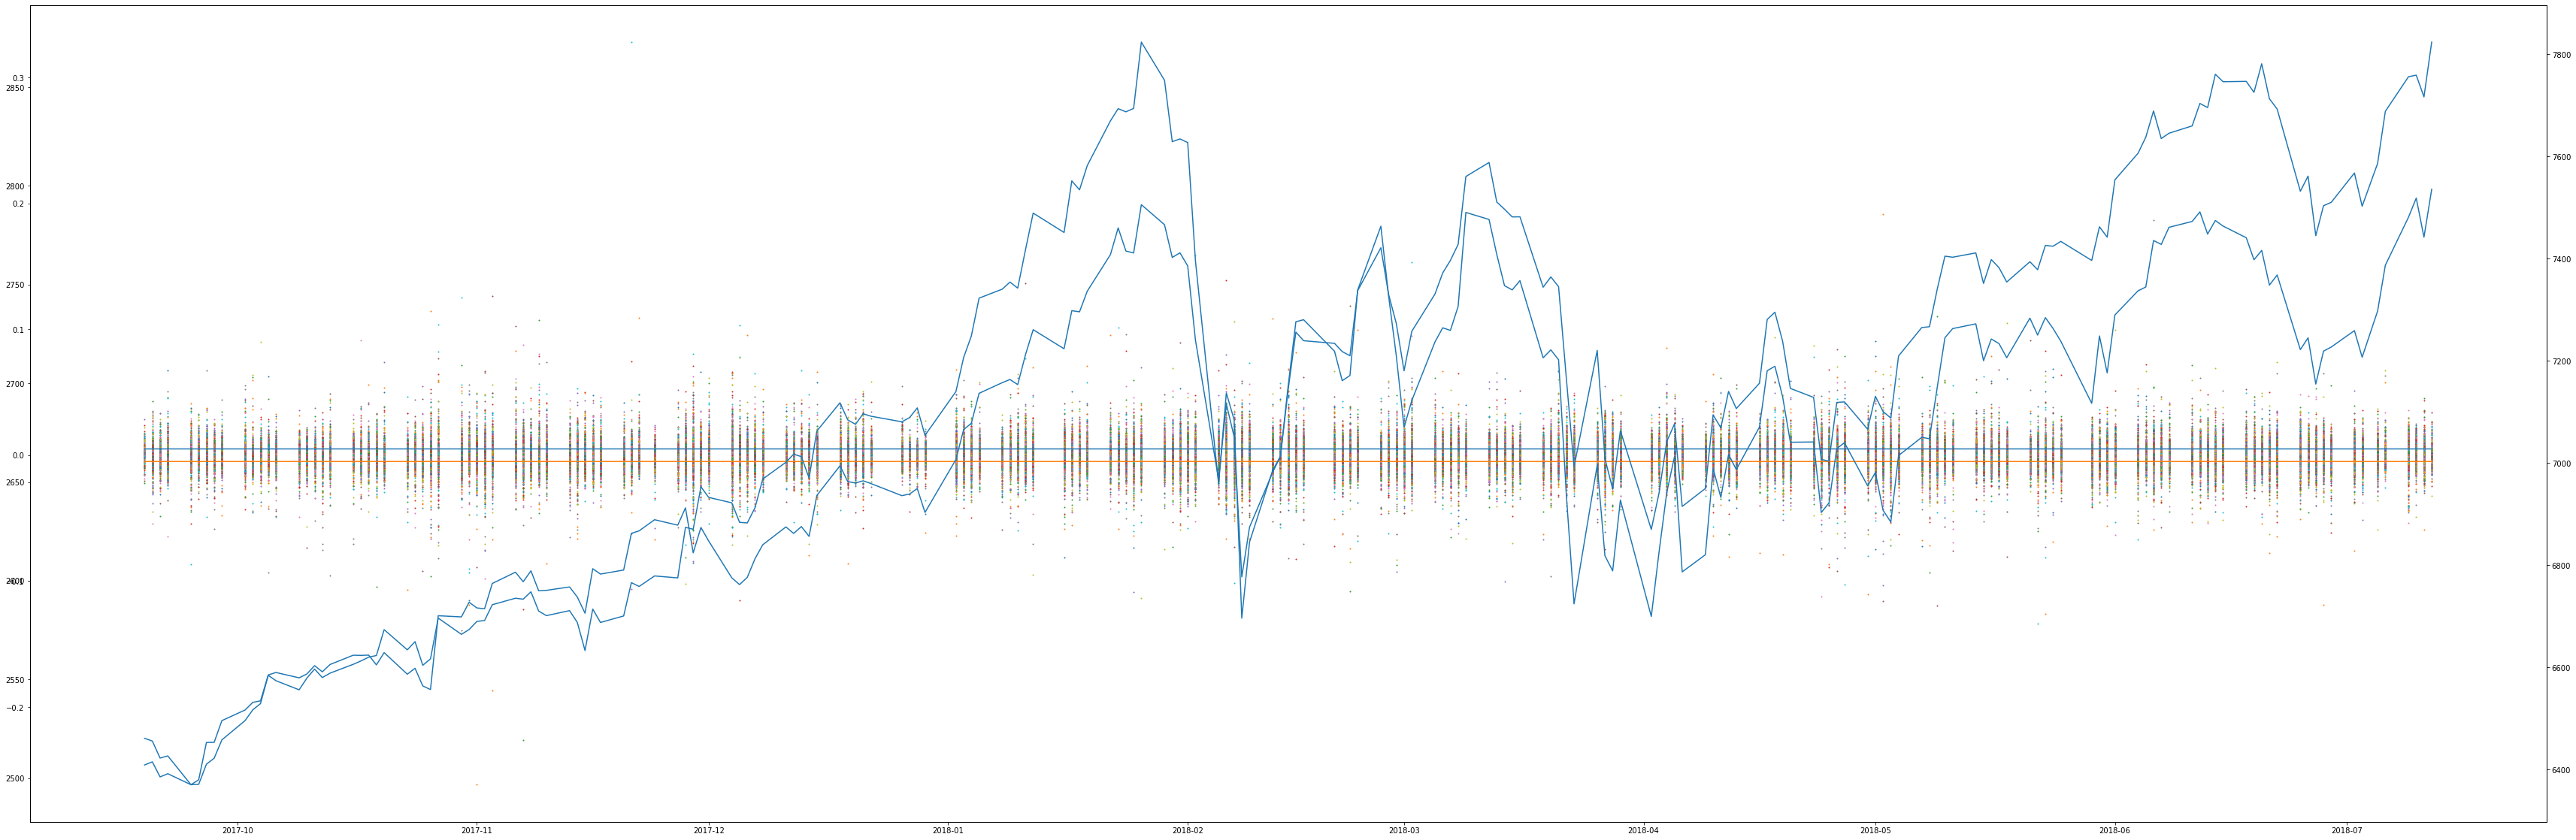

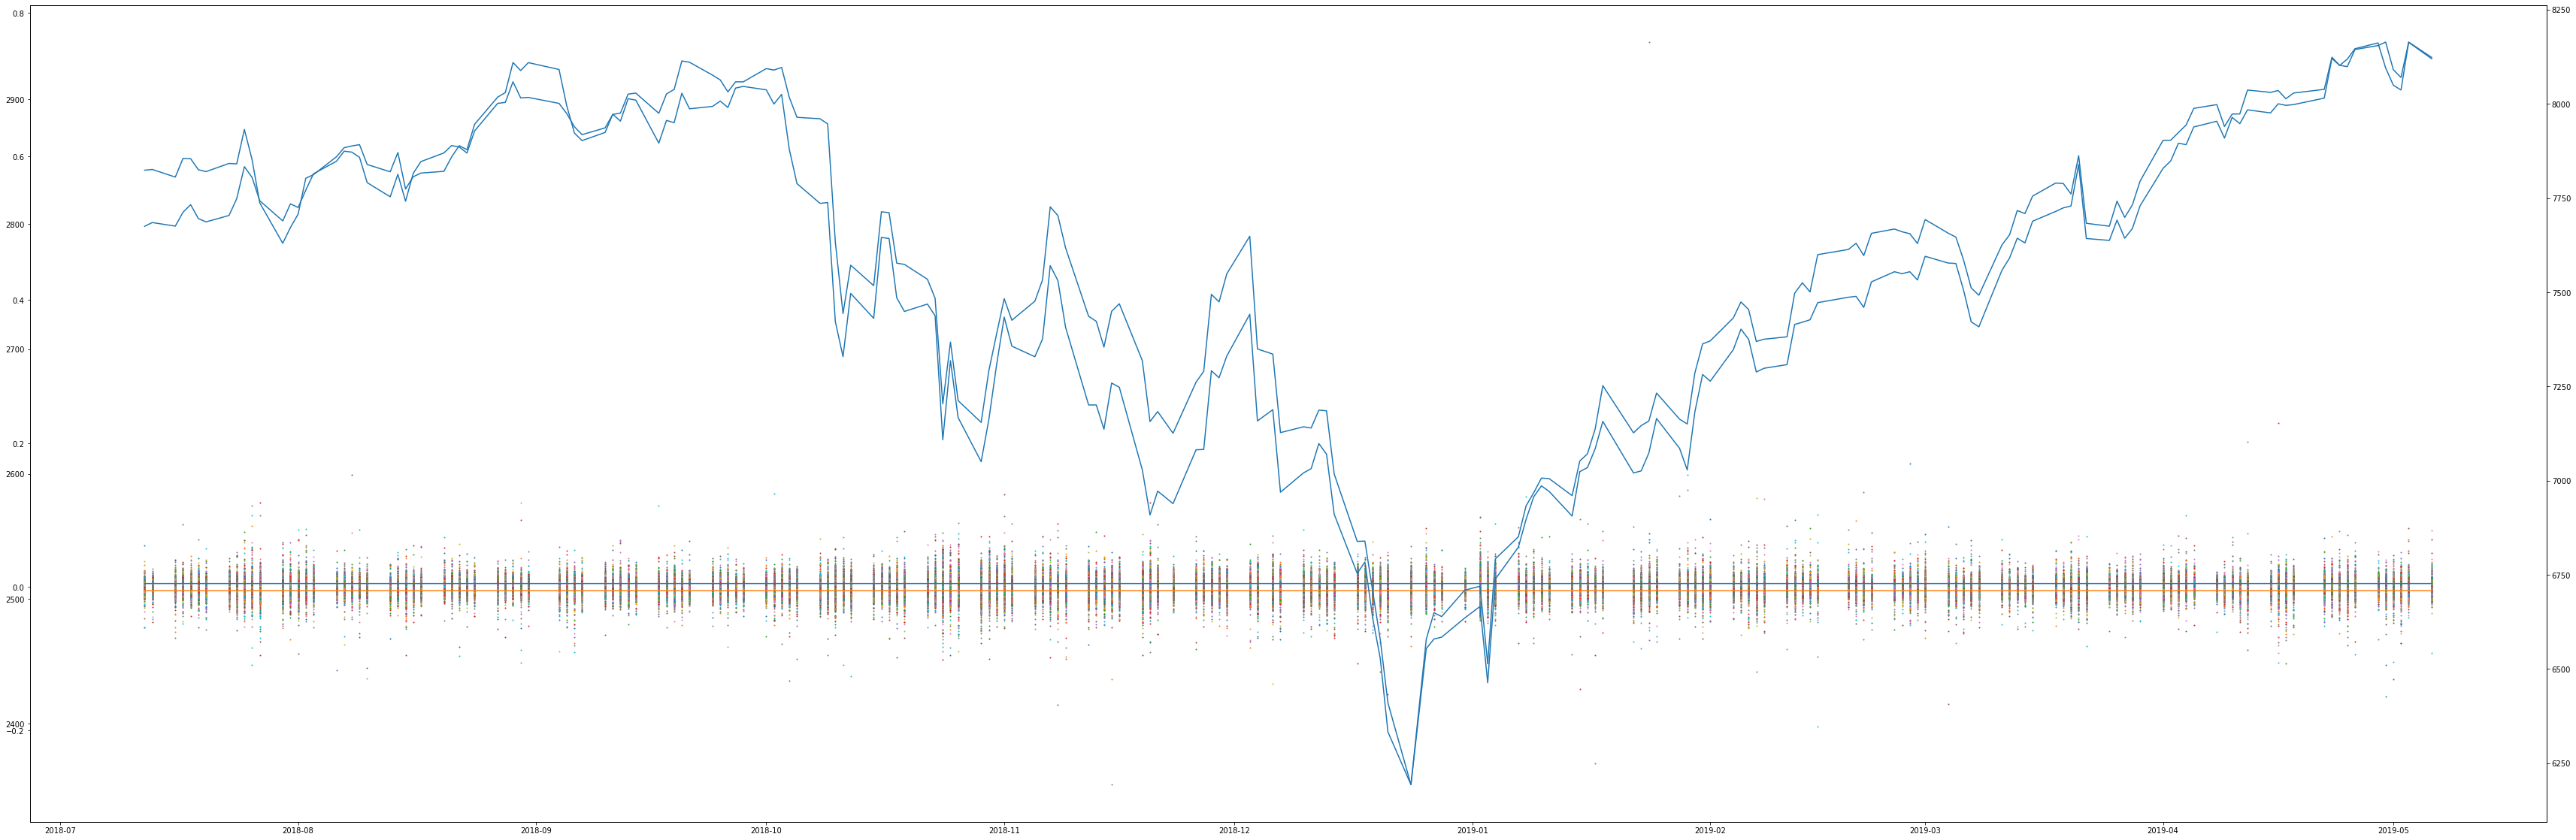

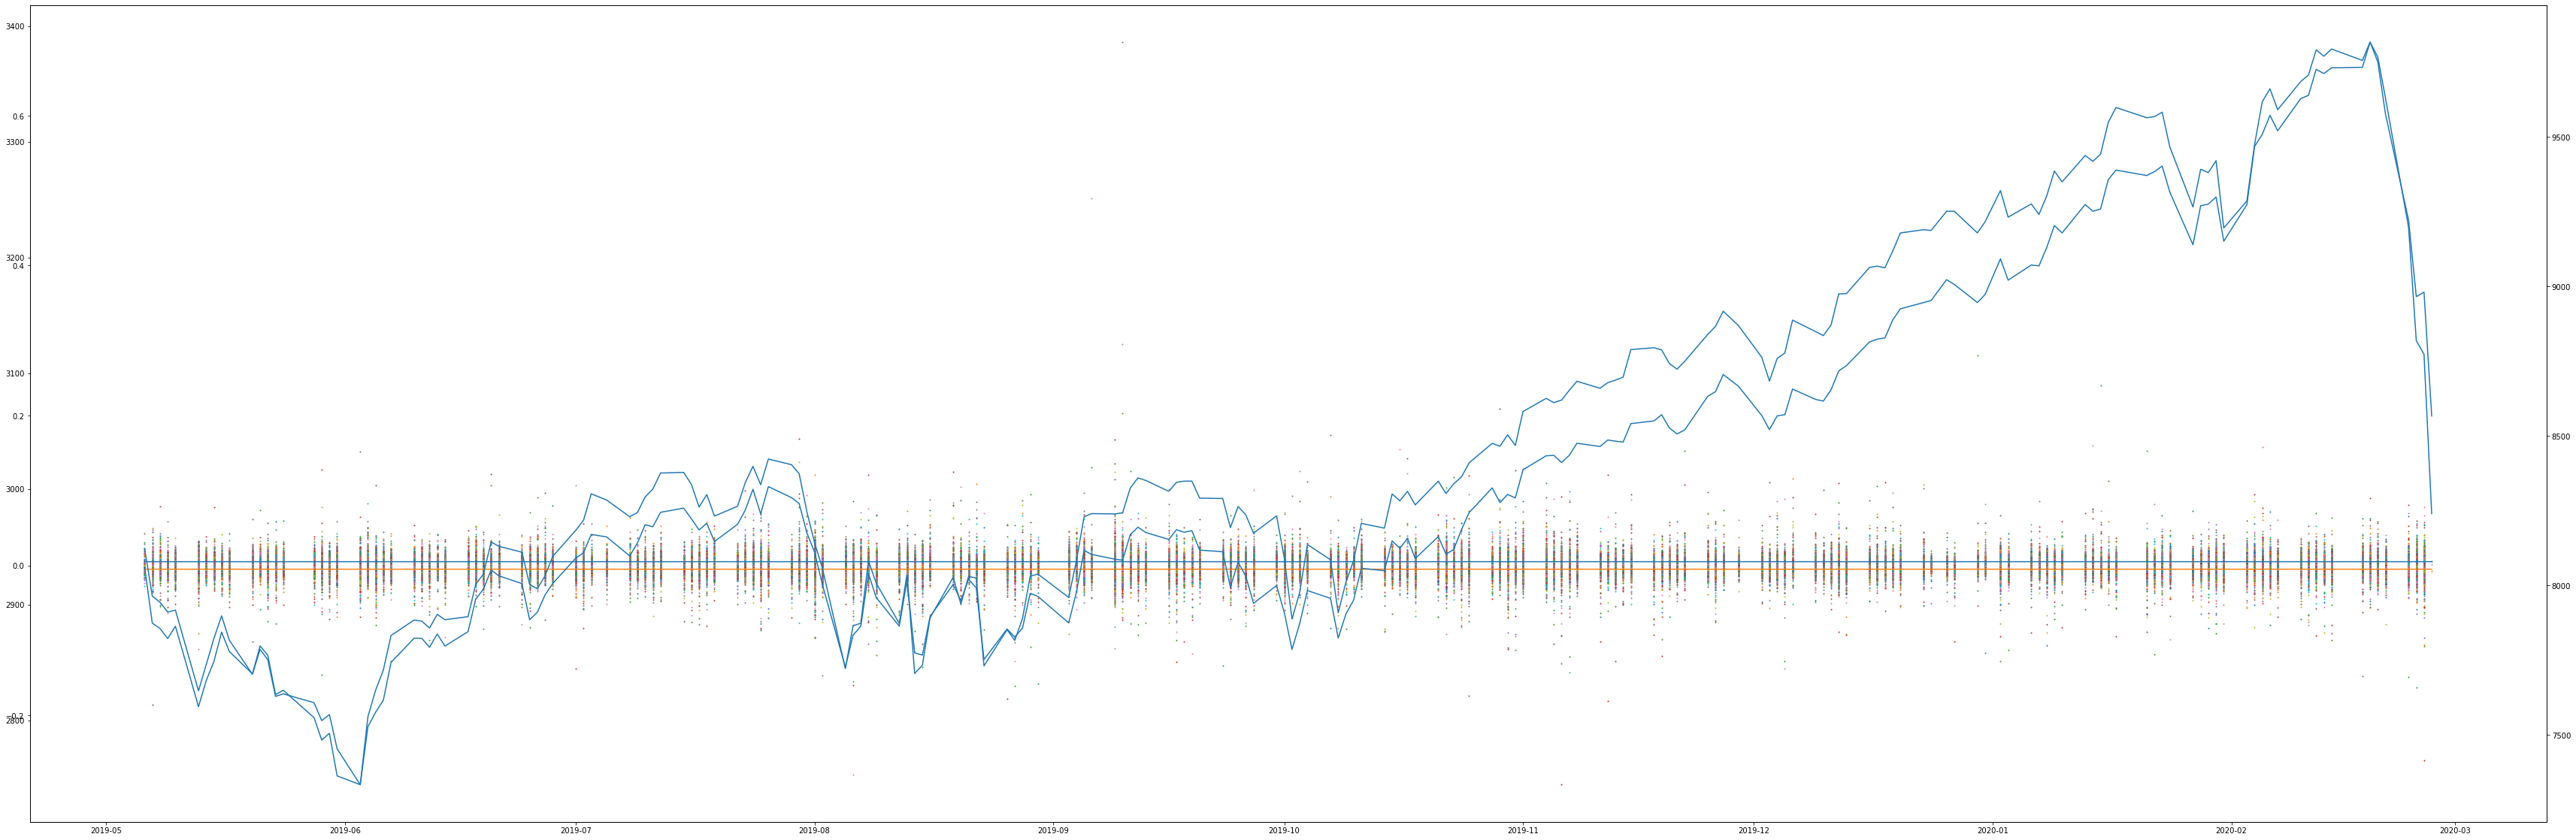

In [3]:
chunkSize = .2
rowCount = combinedDF['Date'].count()
for x in range(5):
    chunk = combinedDF[int(x*chunkSize*rowCount):int((x+1)*chunkSize*rowCount)]
    plotChart(chunk)

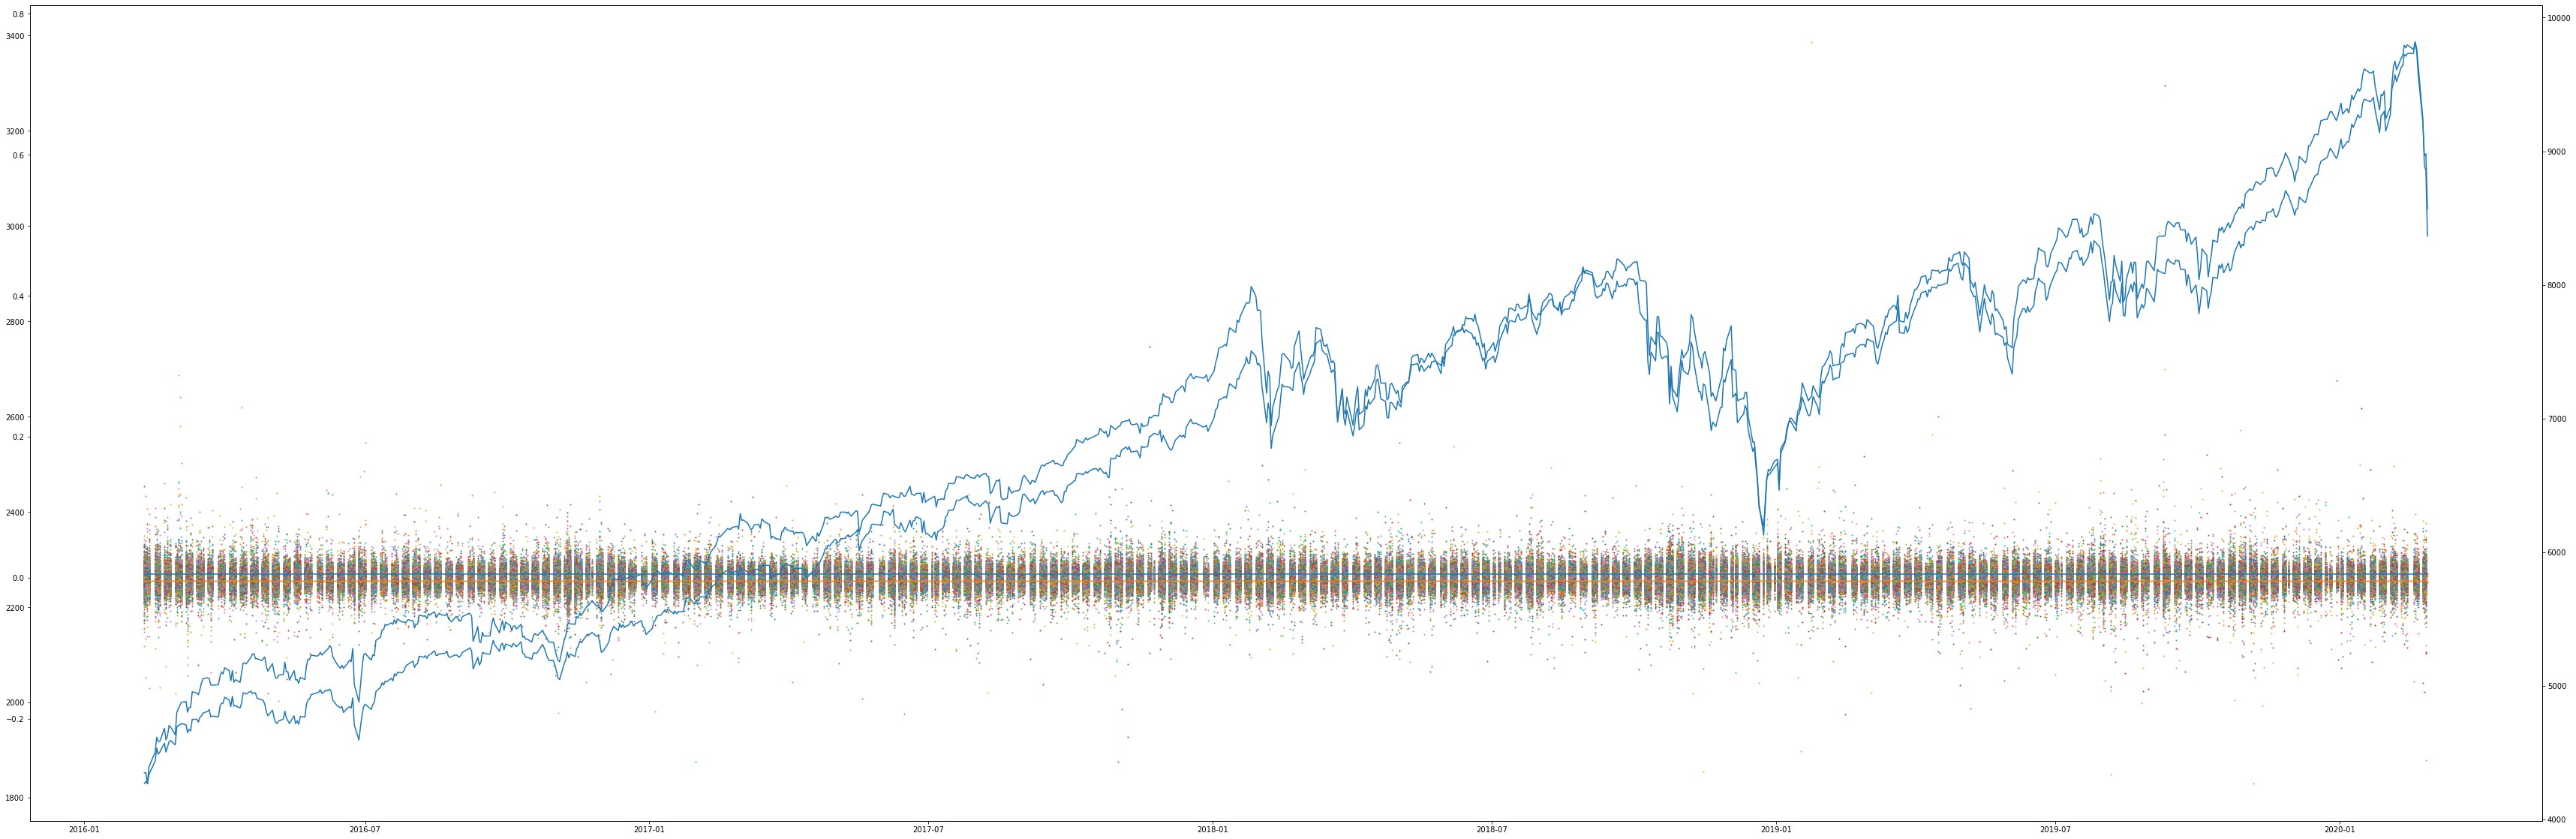

In [4]:
plotChart(combinedDF)

In [ ]:
#get the spread of high/lowest and plot it
daySpread = pd.DataFrame(data = {'Date' : [], 'top' : [], 'bot' : []})
for day in tqdm(combinedDF['Date'].unique()):
    dayDF = combinedDF[combinedDF['Date'] == day]
    toAppend = pd.DataFrame(data= {'Date' : [day],
                            'top' : [dayDF['vsMarketPerformance'].max()], 
                            'bot' : [dayDF['vsMarketPerformance'].min()]})
    daySpread = daySpread.append(toAppend)
print('finished loop')
daySpread['Spread'] = (daySpread['top'] - daySpread['bot'])
print('finished calculating spread')
daySpread['2DaySpreadSmooth'] = genXDayAverage(daySpread, 2, 'Spread')
print('finished smooth')
daySpread = pd.merge(daySpread, combinedDF, right_on = 'Date', left_on = 'Date')
print('finished merge')
chunkSize = .2
rowCount = daySpread['Date'].count()
print('pre printing')
for x in range(5):
    chunk = daySpread[int(x*chunkSize*rowCount):int((x+1)*chunkSize*rowCount)]
    plt.subplots(figsize=(60,20))
    plt.plot(chunk['Date'],chunk['Spread'], c = 'black')
    plt.plot(chunk['Date'],chunk['2DaySpreadSmooth'], c = 'red')
    spxPlot = plt.twinx()
    spxPlot.plot(chunk['Date'], chunk['SP500Value'])
    nasdaqPlot = plt.twinx()
    nasdaqPlot.plot(chunk['Date'], chunk['NASDAQCOMValue'])

100%|██████████| 1020/1020 [00:03<00:00, 259.94it/s]


finished loop
finished calculating spread
kwargs done
preshifting
added a shifted one
added a shifted one


In [ ]:
#get the # of winners vs losers and plot it
